In [1]:
import pandas as pd

# Load Data
Get all the clean data and deduplicate, keeping the last row with each ID (which will be the most recently-pulled).

In [2]:
# Use a glob pattern to pull *all* json files in the clean_data/ folder.
from pathlib import Path
data_files = Path('clean_data').glob('*.json')
df = pd.concat(pd.read_json(filename) for filename in data_files)

In [3]:
# Keep only the last instance of each index (which is a Zillow ID).
df = df.loc[~df.index.duplicated(keep='last')]

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [5]:
gmap = gpd.read_file('chicago.shp')

## Plot Prices
Start with just a look at where the properties are and their price.

In [6]:
from shapely.geometry import Point
points = [Point(y,x) for x, y in zip(df.lat, df.lon)]
gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=points)

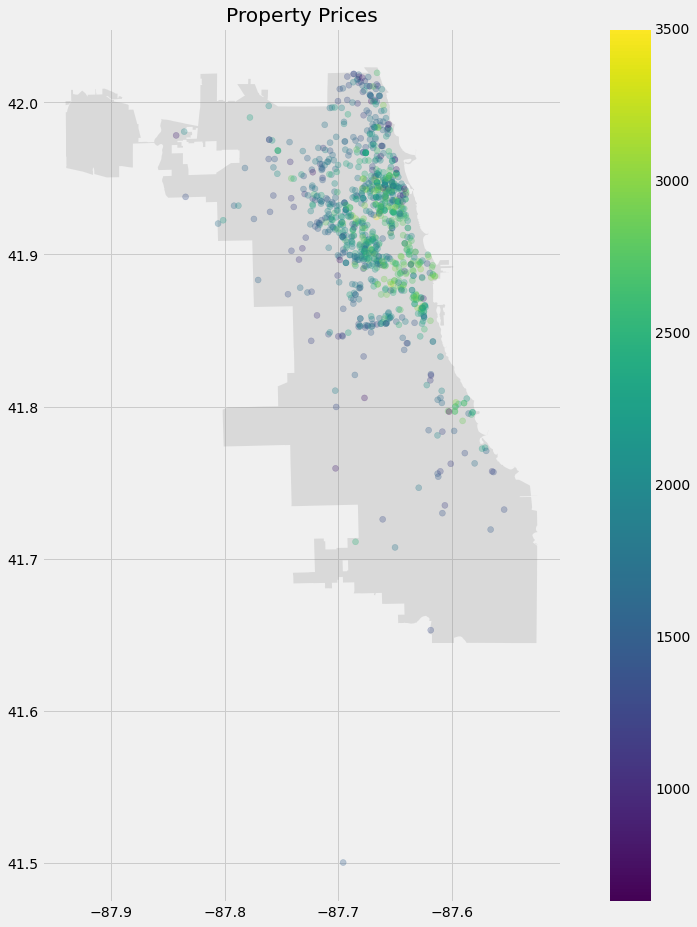

In [7]:
MAP_ALPHA = 0.2
PT_ALPHA = 0.3

fig, ax = plt.subplots(figsize=(15, 15))
gmap.plot(ax=ax, alpha=MAP_ALPHA, color='gray')
gdf.plot(column='price', ax=ax, alpha=PT_ALPHA, marker='o', legend=True)
plt.title('Property Prices');

## Scoring Functions

Define a "total score" function.
I think it's simplest to think of the total score as an aggregation of other factors: price, location, and square footage.
So I'll write functions to score those aspects as well and then use their results in the `total_score` function.

In [8]:
PRICE_SCORE_WT = 0.3
LOC_SCORE_WT = 0.4
SQFT_SCORE_WT = 0.3
def total_score(row):
    # Take a row representing a property and assign it a score based on how much I'll like it.
    p = PRICE_SCORE_WT * row['price_score']
    l = LOC_SCORE_WT * row['loc_score']
    sq = SQFT_SCORE_WT * row['sqft_score']
    return p + l + sq

In [9]:
def price_score(row):
    # No points for pricing below $1600 -- that's alarming for a 2-bedroom.
    price = row['price'] if row['price'] >= 1600 else 1600
    # Every dollar over $2800 counts double
    penalty = max(price-2800, 0)
    price = price + penalty
    return (4200-price) / 2600

In [10]:
def sqft_score(row):
    sqft = row['sqft']
    if pd.isnull(sqft):
        return 0.5
    if sqft < 500:
        sqft = 500
    elif sqft > 2400:
        sqft = 2400
    acceptability = min(sqft, 1000) / (1000 * 2)
    extra = min(max(1000, sqft), 2400) / (1000 * 4)
    return acceptability + extra

In [11]:
ZIP_SCORES = {
    60601: 0.2, # North part of the Loop
    60605: 0.1, # South Loop
    60606: 0.1, # OPO proximity
    60607: 0.8, # UIC & Little Italy
    60608: 0.2, # Pilsen and West Bridgeport
    60610: 0.7, # Gold Coast, Cabrini Green
    60611: 0.1, # Streeterville
    60614: 0.7, # South Lincoln Park
    60613: 0.3, # Wrigleyville and North
    60622: 0.4, # Ukrainian Village, Humboldt Park, some Wicker Park
    60642: 0.6, # Noble Square & Goose Island
    60647: 0.3, # Logan Square and Wicker Park
    60654: 0.1, # River North
    60657: 0.5, # Lakeview
    60661: 0.3, # Greektown
    
}
def loc_score(row):
    if pd.notnull(row['zipcode']):
        if row['zipcode'] in ZIP_SCORES:
            zip_score = ZIP_SCORES[row['zipcode']]
        else:
            zip_score = 0
    else:
        zip_score = 0.3
    # Bonus points for being within a 0.5 miles of my preferred location
    if row['old_town_distance'] <= 1:
        pref_pt_score = (1 - (row['old_town_distance'] ** 2)) / 4
    else:
        pref_pt_score = 0
    return zip_score + pref_pt_score

Score the properties.
Total score must come last since it relies upon the others.

In [12]:
df['loc_score'] = df.apply(loc_score, axis=1)
df['sqft_score'] = df.apply(sqft_score, axis=1)
df['price_score'] = df.apply(price_score, axis=1)
df['total_score'] = df.apply(total_score, axis=1)

While tuning the scoring functions and their weights, it's very useful to be able to look at how your scores are distributed.
Larger ranges in one subscore (e.g. square footage) could overwhelm the impact of another.

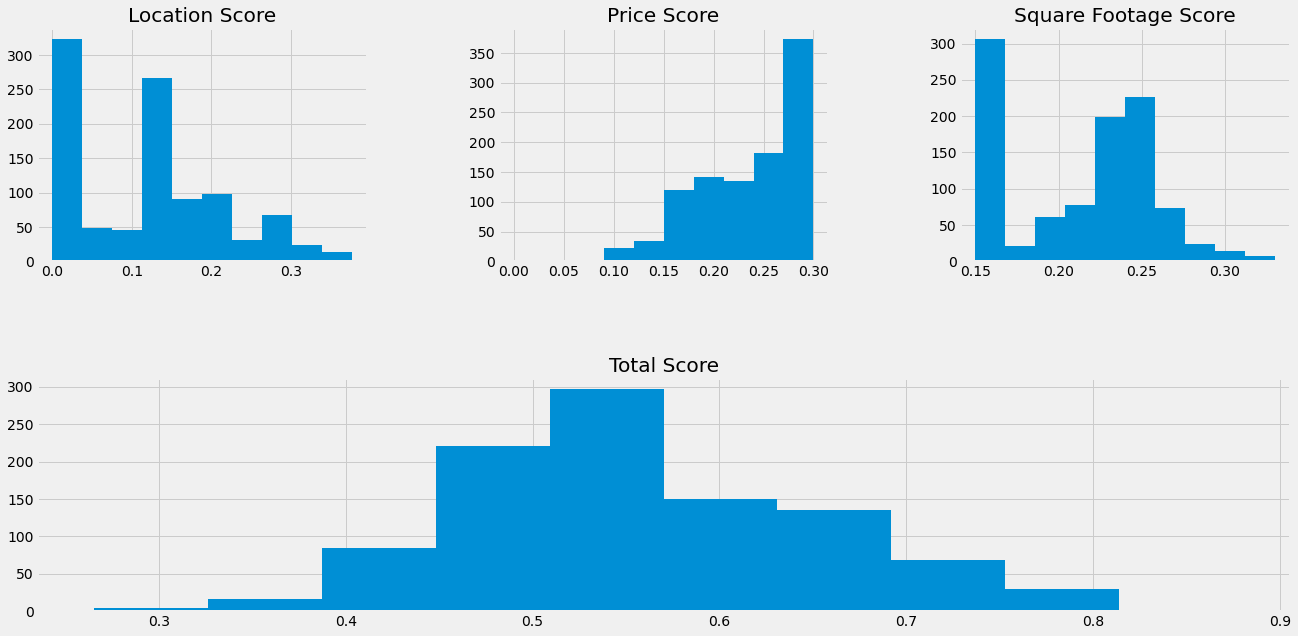

In [13]:
# Weird code in order to lay out the plots as I want.
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.5)

loc_ax = fig.add_subplot(grid[0, 0])
(LOC_SCORE_WT * df.loc_score).hist(ax=loc_ax)
loc_ax.set_title('Location Score')

price_ax = fig.add_subplot(grid[0, 1])
(PRICE_SCORE_WT * df.price_score).hist(ax=price_ax)
price_ax.set_title('Price Score')

sqft_ax = fig.add_subplot(grid[0, 2])
(SQFT_SCORE_WT * df.sqft_score).hist(ax=sqft_ax)
sqft_ax.set_title('Square Footage Score')

main_ax = fig.add_subplot(grid[1, :])
df.total_score.hist(ax=main_ax)
main_ax.set_title('Total Score');

I originally spent some time tweaking this, but at this point it looks pretty good.
I appreciate the total score being somewhat close to normally-distributed.

## Properties to Investigate

At long last, the most promising properties...

In [14]:
promising = df.sort_values('total_score', ascending=False)
promising.head()

,price,address,lat,lon,zipcode,url,days_on_zillow,beds,baths,sqft,type,old_town_distance,geometry,loc_score,sqft_score,price_score,total_score
zpid_2102990066,1750,"1612 N Sedgwick St APT 2F, Chicago, IL 60614",41.911496,-87.638948,60614.0,https://www.zillow.com/homedetails/1612-N-Sedg...,0,2.0,1.0,1000.0,unit,0.358998,POINT (-87.63895 41.91150),0.917780,0.750,0.942308,0.874804
zpid_2092425346,1945,"1628 N Wells St #2, Chicago, IL 60614",41.912048,-87.635287,60614.0,https://www.zillow.com/homedetails/1628-N-Well...,1,2.0,1.0,1100.0,unit,0.200277,POINT (-87.63529 41.91205),0.939972,0.775,0.867308,0.868681
zpid_2113176683,1775,"2450 N Southport Ave #1, Chicago, IL 60614",41.926742,-87.663701,60614.0,https://www.zillow.com/homedetails/2450-N-Sout...,0,2.0,1.0,1280.0,unit,1.981649,POINT (-87.66370 41.92674),0.700000,0.820,0.932692,0.805808
zpid_2112903578,1795,"2758 N Ashland Ave APT 2F, Chicago, IL 60614",41.932283,-87.668743,60614.0,https://www.zillow.com/homedetails/2758-N-Ashl...,0,2.0,1.0,1300.0,unit,2.419128,POINT (-87.66874 41.93228),0.700000,0.825,0.925000,0.805000
zpid_2072152146,1890,"869 N Lasalle St #2, Chicago, IL 60610",41.898149,-87.632834,60610.0,https://www.zillow.com/homedetails/869-N-Lasal...,0,2.0,1.0,1000.0,unit,0.840849,POINT (-87.63283 41.89815),0.773243,0.750,0.888462,0.800836


Unfortunately, we can't see the full URL links in the DataFrame preview.
Let's print them out in our own custom HTML as links, with relevant info inline.

In [15]:
from IPython.display import HTML

# Look at the top 20 properties.
N = 20

# Build a line of HTML, including a link, for each property, and put them in this list.
h = []
for i, (_, row) in enumerate(promising.iloc[:N].iterrows(), 1):
    h.append(f'{i}. <a href="{row.url}">{row.address}</a> '
             f'-- ${row.price}, {row.beds} beds, {row.baths} baths, {row.sqft} sqft '
             f'--  Total score: <b>{row.total_score:.3f}</b>')
html = '<br>'.join(h)
HTML(html)

## Scores by Zipcode

In [16]:
# Get the 9 zipcodes with the most properties
zips = df.zipcode.value_counts().iloc[:9].index

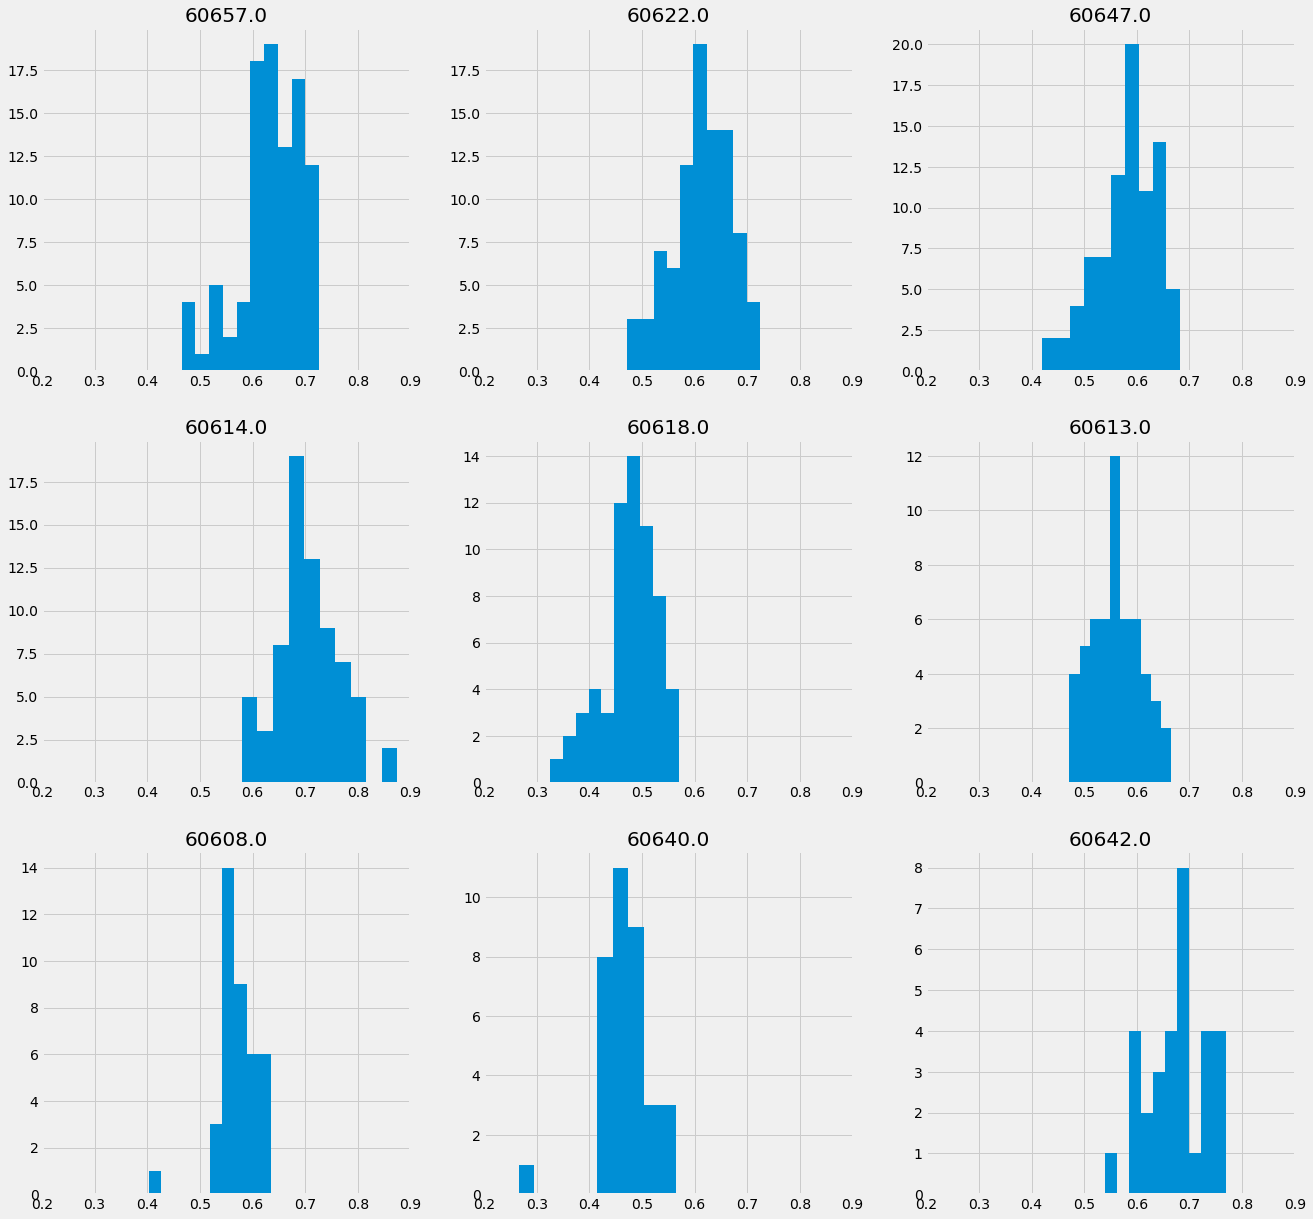

In [17]:
# It's important to keep all the X-axes constant to do visual comparisons.
# I had to experiment a bit to get a value here that didn't cut off any bars.
X_LIM = (0.2, 0.9)

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i, z in enumerate(zips):
    sub_df = df[df.zipcode == z]
    x, y = divmod(i, 3)
    sub_df.total_score.hist(ax=ax[x, y])
    ax[x, y].set_xlim(*X_LIM)
    ax[x, y].set_title(z)

## Map View
Let's plot the scores on the map

In [18]:
points = [Point(y,x) for x, y in zip(df.lat, df.lon)]
gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=points)

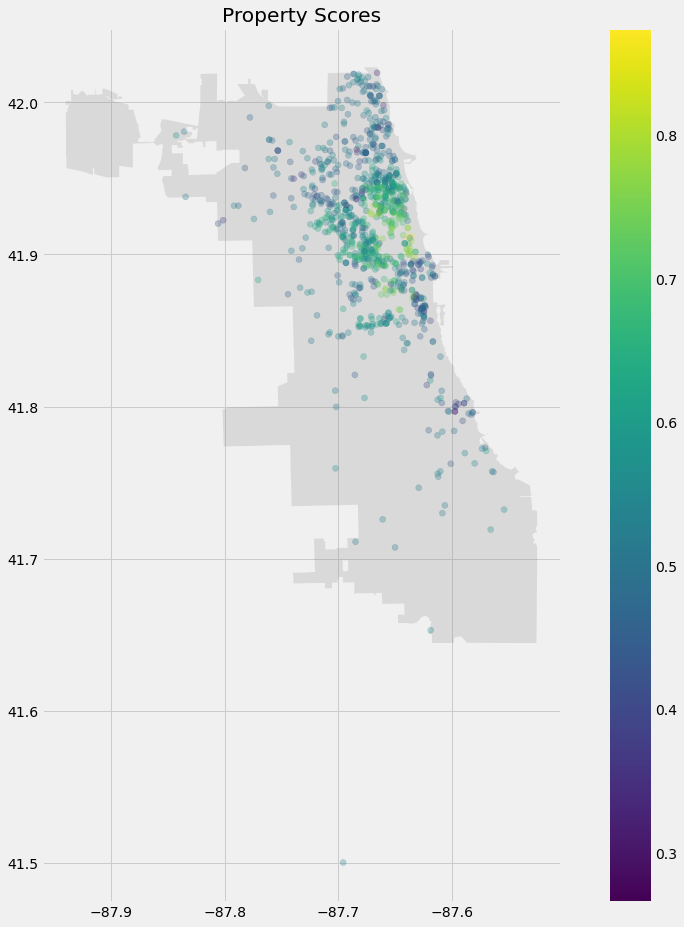

In [19]:
MAP_ALPHA = 0.2
PT_ALPHA = 0.3

fig, ax = plt.subplots(figsize=(15, 15))
gmap.plot(ax=ax, alpha=MAP_ALPHA, color='gray')
gdf.plot(column='total_score', ax=ax, alpha=PT_ALPHA, marker='o', legend=True)
plt.title('Property Scores');